In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *

import phate
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# symsim_r1b1 = endoRNA_noIAC(standardize=False)
# symsim_r1b2 = endoATAC_noIAC(standardize=False)
rna_dataset = endo_rna(standardize=False)
atac_dataset = endo_atac(standardize=False)

In [3]:
fig_dir = "./result/endo/"

In [4]:
rna_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 64, 4], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': 128,
    'layers': [512, 256, 64, 4], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


In [5]:
train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    _, Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 20, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 40)

    Diff1 = torch.FloatTensor(Diff1).to(device)
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["raw"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())
    # X_pca1 = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(data["raw"].numpy()))
    


for data in test_atac_loader:
    _, Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 100, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 70)
    

    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["raw"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())
    # X_pca2 = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(data["raw"].numpy()))


In [21]:
encoder1 = ae.Encoder(rna_CONFIG)
encoder2 = ae.Encoder(atac_CONFIG)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 5e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 5e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)



In [22]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1] + 2, hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [23]:
utils.pretrain_embedding(encoder1 = encoder1, encoder2 = encoder2, fusion = fusion, decoder1 = decoder1, decoder2 = decoder2, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, n_epochs = 101, lamb_r1 = 0.5, lamb_r2 = 0.5, dist_mode = "mse")

epoch:  0 RNA recon loss: 0.73244, RNA dist loss: 0.30593 ATAC recon loss: 0.87141, ATAC dist loss: 0.43379
epoch:  10 RNA recon loss: 0.10030, RNA dist loss: 0.07596 ATAC recon loss: 0.02162, ATAC dist loss: 0.09216
epoch:  20 RNA recon loss: 0.07813, RNA dist loss: 0.06624 ATAC recon loss: 0.01111, ATAC dist loss: 0.07702
epoch:  30 RNA recon loss: 0.06378, RNA dist loss: 0.07370 ATAC recon loss: 0.01069, ATAC dist loss: 0.07295
epoch:  40 RNA recon loss: 0.05626, RNA dist loss: 0.03737 ATAC recon loss: 0.00673, ATAC dist loss: 0.05775
epoch:  50 RNA recon loss: 0.05014, RNA dist loss: 0.03344 ATAC recon loss: 0.00535, ATAC dist loss: 0.06187
epoch:  60 RNA recon loss: 0.04675, RNA dist loss: 0.03524 ATAC recon loss: 0.00374, ATAC dist loss: 0.04907
epoch:  70 RNA recon loss: 0.04431, RNA dist loss: 0.03333 ATAC recon loss: 0.00594, ATAC dist loss: 0.05597
epoch:  80 RNA recon loss: 0.04668, RNA dist loss: 0.04271 ATAC recon loss: 0.00475, ATAC dist loss: 0.03612
epoch:  90 RNA recon

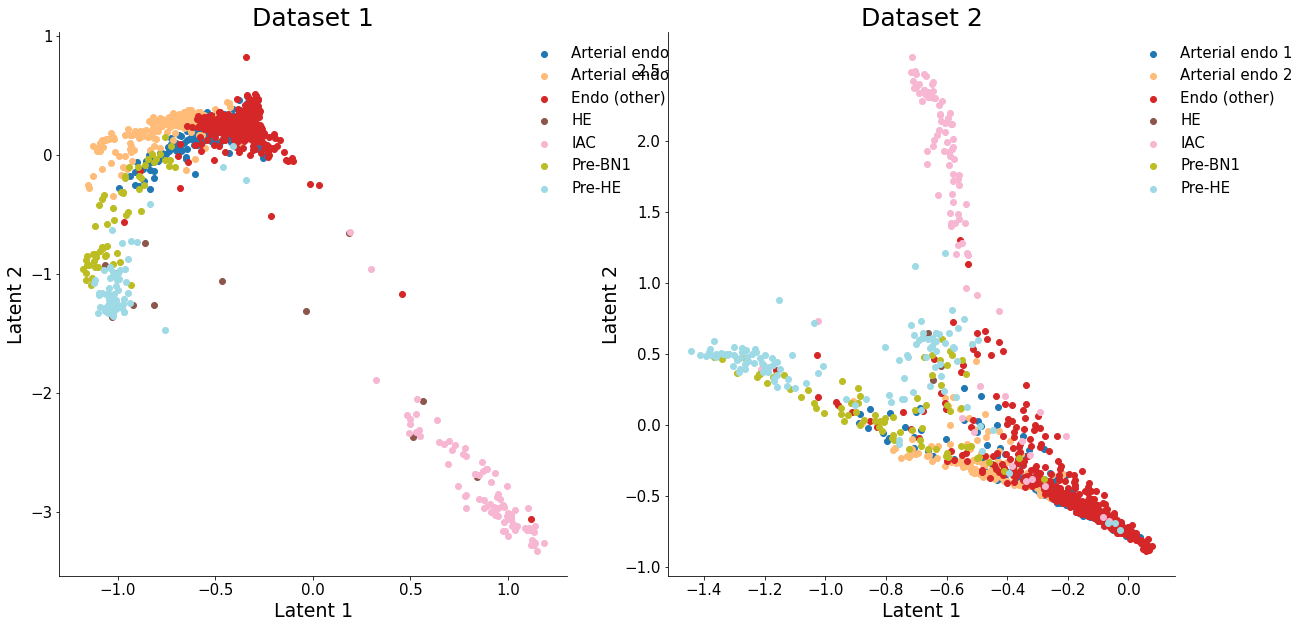

In [24]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [25]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, fusion = fusion, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 101, use_anchor = False)

epoch:  0 Discriminator loss: 0.68401
epoch:  10 Discriminator loss: 0.44939
epoch:  20 Discriminator loss: 0.23328
epoch:  30 Discriminator loss: 0.15236
epoch:  40 Discriminator loss: 0.10448
epoch:  50 Discriminator loss: 0.09097
epoch:  60 Discriminator loss: 0.09097
epoch:  70 Discriminator loss: 0.08800
epoch:  80 Discriminator loss: 0.07066
epoch:  90 Discriminator loss: 0.09551
epoch:  100 Discriminator loss: 0.08905


In [26]:
# n_iter = 200 merge too good
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=201, n_iter=71, n_iter2 = 2, lamb_r1 = 1, lamb_r2 = 1, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA recon loss: 0.09803, RNA dist loss: 0.37049 ATAC recon loss: 0.01528, ATAC dist loss: 0.10922 Discriminator loss: 0.27017
epoch:  10 RNA recon loss: 0.10761, RNA dist loss: 0.20229 ATAC recon loss: 0.01019, ATAC dist loss: 0.11173 Discriminator loss: 0.56055
epoch:  20 RNA recon loss: 0.09490, RNA dist loss: 0.18859 ATAC recon loss: 0.01074, ATAC dist loss: 0.09962 Discriminator loss: 0.62105
epoch:  30 RNA recon loss: 0.08185, RNA dist loss: 0.18048 ATAC recon loss: 0.01150, ATAC dist loss: 0.11273 Discriminator loss: 0.58819
epoch:  40 RNA recon loss: 0.07713, RNA dist loss: 0.18506 ATAC recon loss: 0.00887, ATAC dist loss: 0.09489 Discriminator loss: 0.63004
epoch:  50 RNA recon loss: 0.07580, RNA dist loss: 0.17733 ATAC recon loss: 0.01071, ATAC dist loss: 0.15244 Discriminator loss: 0.61080
epoch:  60 RNA recon loss: 0.06897, RNA dist loss: 0.21264 ATAC recon loss: 0.01206, ATAC dist loss: 0.10745 Discriminator loss: 0.64880
epoch:  70 RNA recon loss: 0.06148, RNA di

In [16]:
# torch.save({
#     'encoder1': encoder1.state_dict(),
#     'encoder2': encoder2.state_dict(),
#     'disc': disc.state_dict(),
#     'fusion': fusion.state_dict(),
#     'decoder1': decoder1.state_dict(),
#     'decoder2': decoder2.state_dict(),
#     'config1': rna_CONFIG,
#     'config2': atac_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/endo_phate_new_withIAC3_pretrain_2latent.pt')

In [17]:
# state = torch.load('./saved_model/endo_phate_new_withIAC3_pretrain_2latent.pt')

# encoder1 = ae.Encoder(rna_CONFIG).to(device)
# encoder1.load_state_dict(state['encoder1'])

# encoder2 = ae.Encoder(atac_CONFIG).to(device)
# encoder2.load_state_dict(state['encoder2'])

# fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 2, embed_channels = 2, activation = False, use_hidden = False)
# fusion.load_state_dict(state['fusion'])

# decoder1 = ae.Decoder(rna_CONFIG).to(device)
# decoder1.load_state_dict(state['decoder1'])

# decoder2 = ae.Decoder(atac_CONFIG).to(device)
# decoder2.load_state_dict(state['decoder2'])

# disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1], hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
# disc.load_state_dict(state['disc'])

<All keys matched successfully>

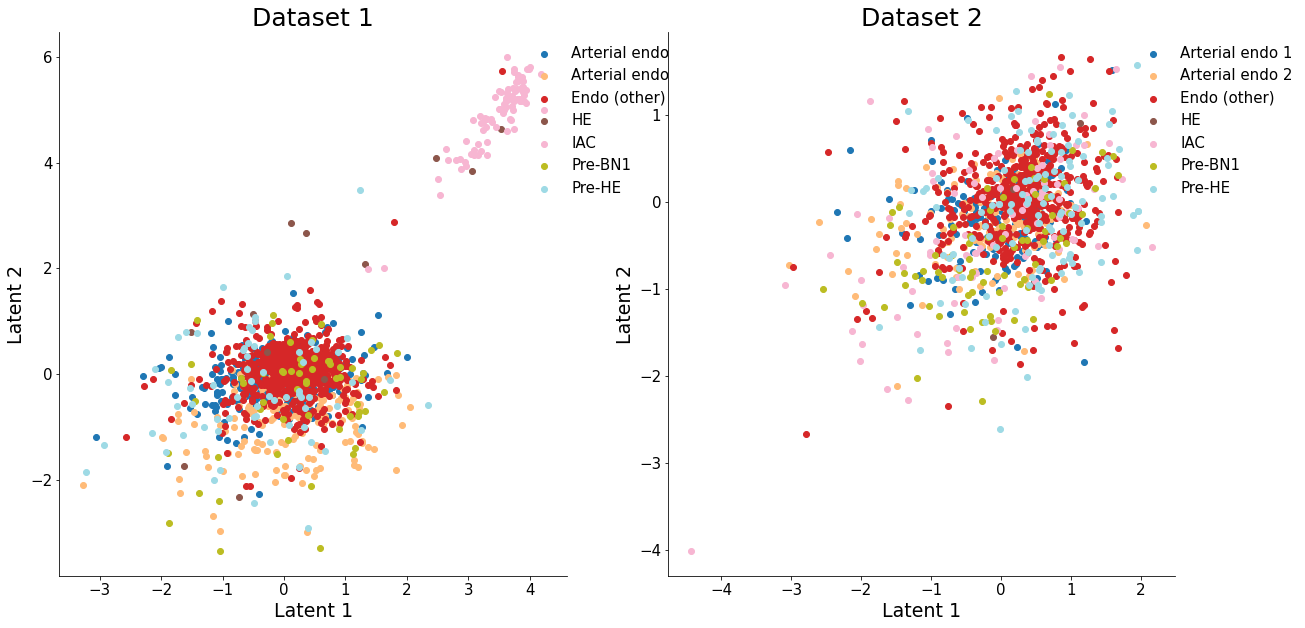

In [31]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = (encoder1(data['count'].to(device))).cpu().detach().numpy()[:,0:2]

    for data in test_atac_loader:
        ae_coordinates2 = (encoder2(data['count'].to(device))).cpu().detach().numpy()[:,0:2]

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save =  fig_dir + "latent_12.png")

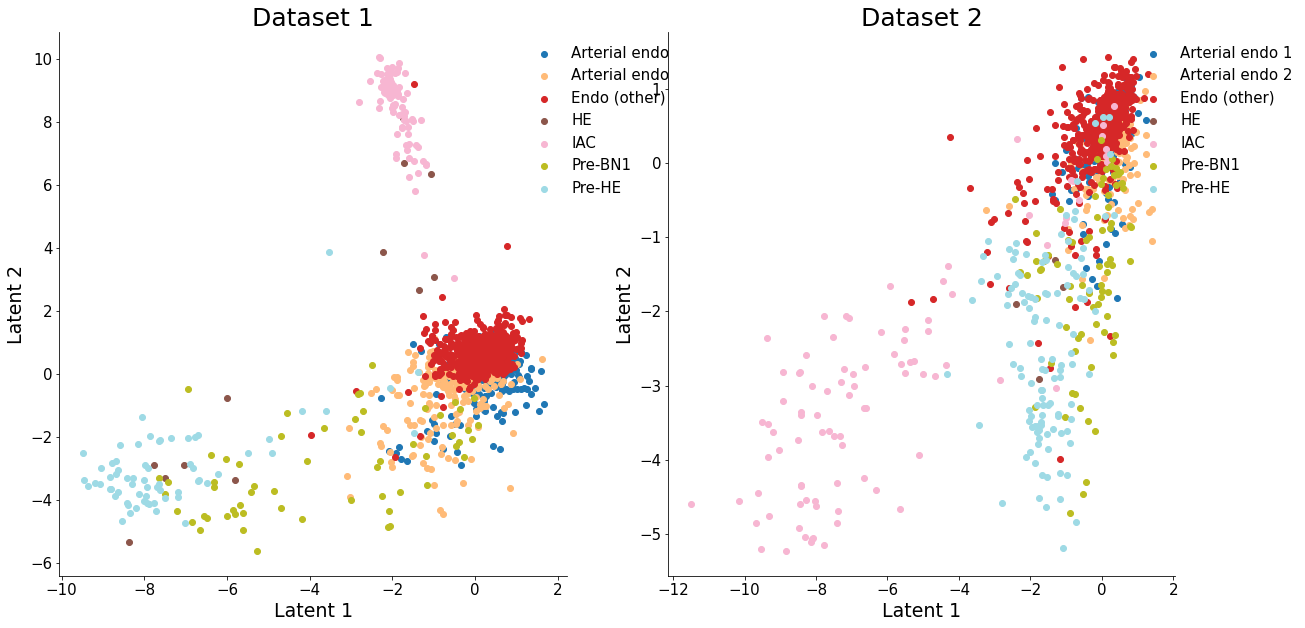

In [32]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = (encoder1(data['count'].to(device))).cpu().detach().numpy()[:,2:4]

    for data in test_atac_loader:
        ae_coordinates2 = (encoder2(data['count'].to(device))).cpu().detach().numpy()[:,2:4]

    utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = fig_dir +"latent_34.png")

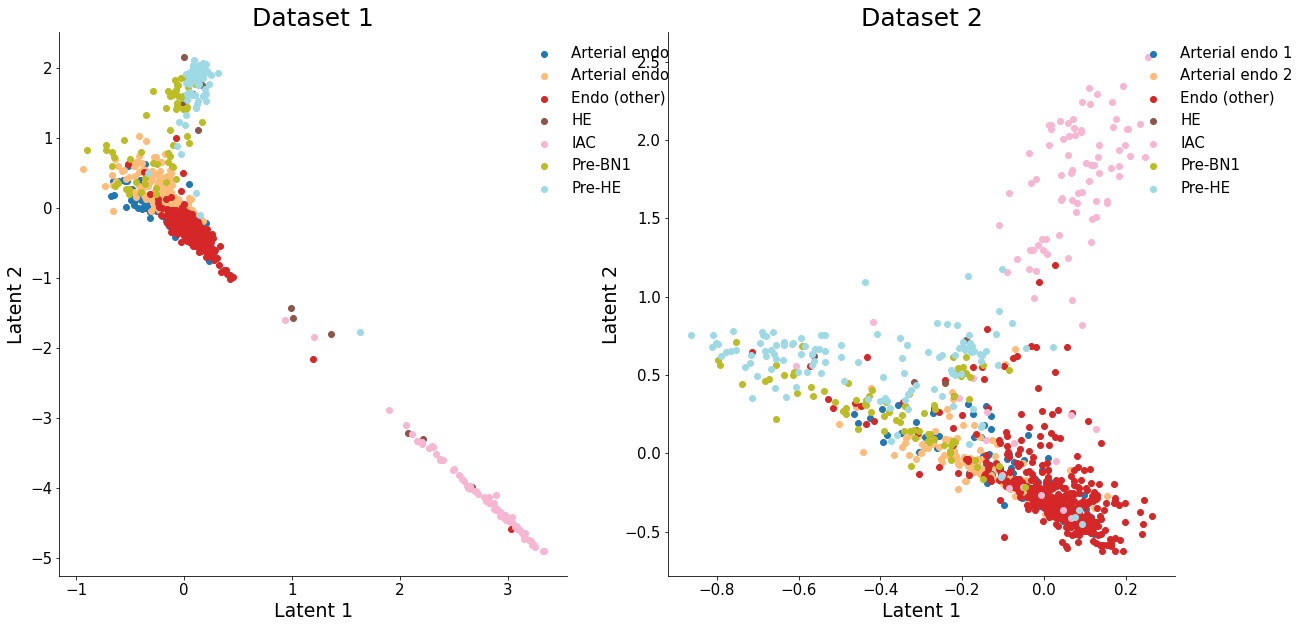

In [33]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = fig_dir + "deep_separate.png")

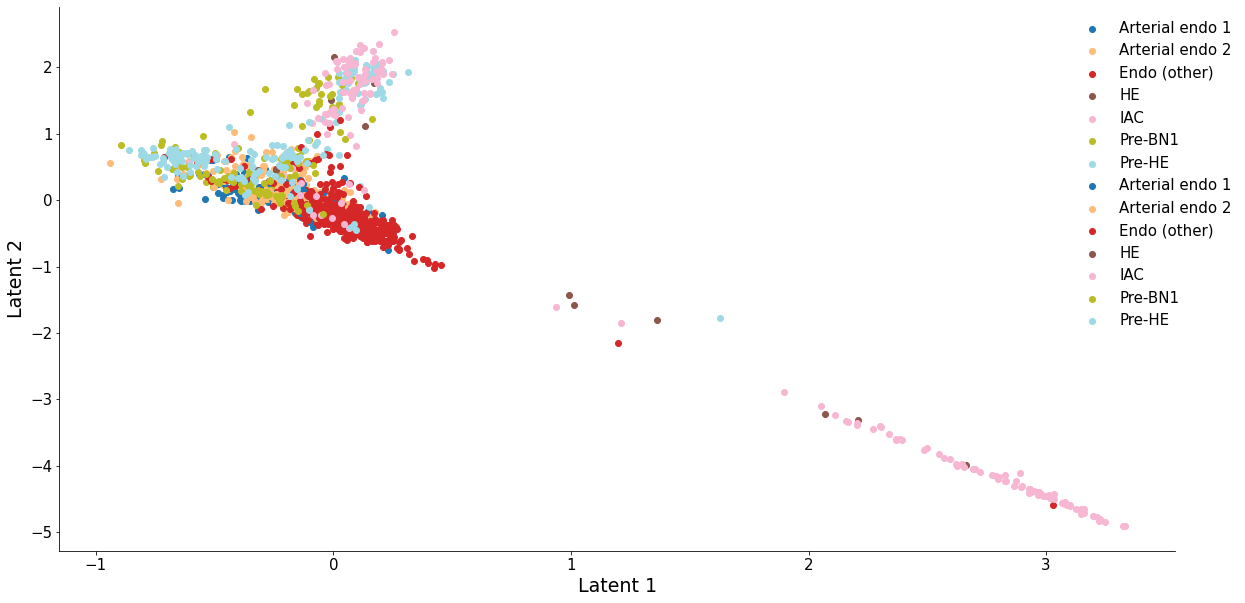

In [34]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = fig_dir + "deep_joint.png")